In this pre-release demo, we use PyAirbyte to extract product-related data from Shopify, followed by a series of transformations and analyses to derive meaningful insights from this data.

### Prerequisites:
- An active [Shopify store](https://www.shopify.com/).

For more information about setting up your Shopify store to work with PyAirbyte, check the [docs](https://docs.airbyte.com/integrations/sources/shopify).

## Install PyAirbyte

In [ ]:
# Add virtual environment support for running in Google Colab
!apt-get install -qq python3.10-venv

# Install PyAirbyte
%pip install --quiet airbyte

## Configure the source PyAirbyte connector

In this section, we configure the Shopify source connector to access product data via PyAirbyte. The connector is configured with necessary parameters like the store name and credentials. [Check the docs](https://docs.airbyte.com/integrations/sources/shopify) for more details on this configuration.

After configuring the source connector, we perform a `check()` to ensure that the configuration is correct and the connection to Shopify is successful.

*Note*: Some config details are retrieved securely using Colab's `userdata`, ensuring that sensitive credentials are not hard-coded into the notebook. Make sure to add your information to the Secrets section on the left.

In [2]:
import airbyte as ab
from google.colab import userdata

# Create and configure the source connector:
source = ab.get_source(
    "source-shopify",
    install_if_missing=True,
    config={
        "shop": userdata.get("SHOP"),
        "credentials": {
            "auth_method": "api_password",
            "api_password": userdata.get("SHOP_API_PASSWORD")
        }
    }
)

# Verify the config and creds by running `check()`:
source.check()

Installing 'source-shopify' into virtual environment '/content/.venv-source-shopify'.
Running 'pip install airbyte-source-shopify'...

Connector 'source-shopify' installed successfully!
For more information, see the source-shopify documentation:
https://docs.airbyte.com/integrations/sources/shopify#reference

Connection check succeeded for `source-shopify`.

## Load source data from Shopify to local DuckDB cache

Now, we list the available streams for the source Shopify. This is optional but can be useful.

Then, we select the streams we want to sync to the local cache, and proceed to `read()` to get the records.

In [ ]:
# List the available streams available for the Shopify source
source.get_available_streams()

In [4]:
# Select the streams we are interested in loading to cache
source.select_streams(["products", "product_variants", "collections", "customers"])

# Read into DuckDB local default cache
cache = ab.get_default_cache()
result = source.read(cache=cache)

## Read Progress

Started reading at 22:20:53.

Read **52** records over **16 seconds** (3.2 records / second).

Wrote **52** records over 4 batches.

Finished reading at 22:21:09.

Started finalizing streams at 22:21:09.

Finalized **4** batches over 1 seconds.

Completed 4 out of 4 streams:

  - product_variants
  - products
  - customers
  - collections


Completed writing at 22:21:10. Total time elapsed: 17 seconds


------------------------------------------------


Completed `source-shopify` read operation at 22:21:10.

## Read data from the cache

Now we can read from the already-written DuckDB cache into a pandas Dataframe. After the data is in the cache, we can read it without re-configuring or re-creating the source object. We can also select a stream to read from.

In [5]:
# Read from the cache into a pandas Dataframe:
products = cache["products"].to_pandas()
product_variants = cache["product_variants"].to_pandas()
collections = cache["collections"].to_pandas()
customers = cache["customers"].to_pandas()

## Data analysis

Let's analyze the data!

Please note that since we used a Shopify sample store for this demo, the data is limited. If you have access to an actual store, you can select more streams and do a more extensive analysis here.

### 1. Product Category and Variant Analysis
Analyze product types, variants, and their inventory levels.

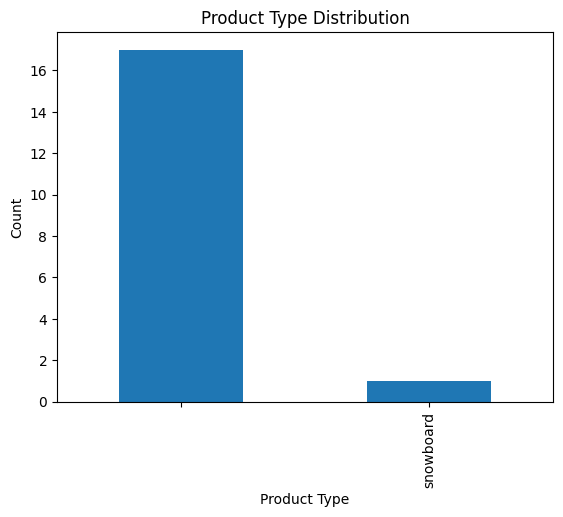

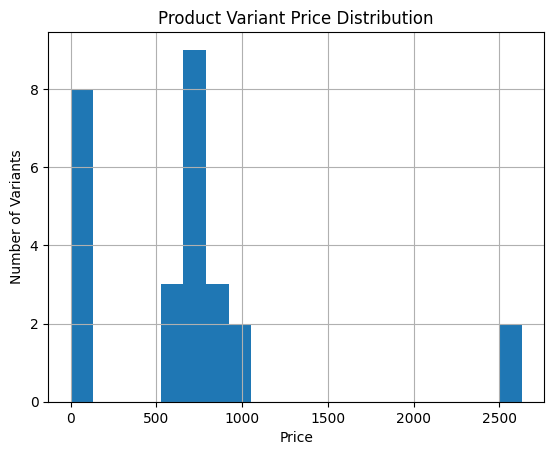

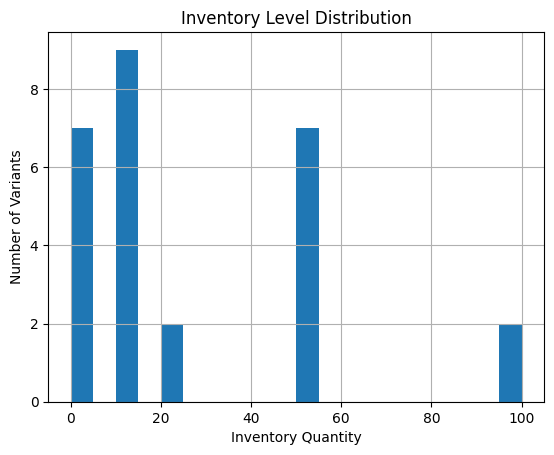

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Product Type Analysis
product_type_counts = products['product_type'].value_counts()
product_type_counts.plot(kind='bar')
plt.title('Product Type Distribution')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()

# Variant Price Range Analysis
product_variants['price'] = pd.to_numeric(product_variants['price'], errors='coerce')
product_variants['price'].hist(bins=20)
plt.title('Product Variant Price Distribution')
plt.xlabel('Price')
plt.ylabel('Number of Variants')
plt.show()

# Inventory Level Analysis
product_variants['inventory_quantity'] = pd.to_numeric(product_variants['inventory_quantity'], errors='coerce')
product_variants['inventory_quantity'].hist(bins=20)
plt.title('Inventory Level Distribution')
plt.xlabel('Inventory Quantity')
plt.ylabel('Number of Variants')
plt.show()

### 2. Customer Segmentation
Segment customers based on available attributes.

In [7]:
import json

# Parse JSON
def parse_json(x):
    try:
        return json.loads(x.replace("'", "\""))
    except:
        return {}

# Apply the function to unpack JSON content
customers['email_marketing_consent'] = customers['email_marketing_consent'].apply(parse_json)

# Extract relevant fields
customers['consent_opt_in_level'] = customers['email_marketing_consent'].apply(lambda x: x.get('opt_in_level', None))
customers['consent_state'] = customers['email_marketing_consent'].apply(lambda x: x.get('state', None))

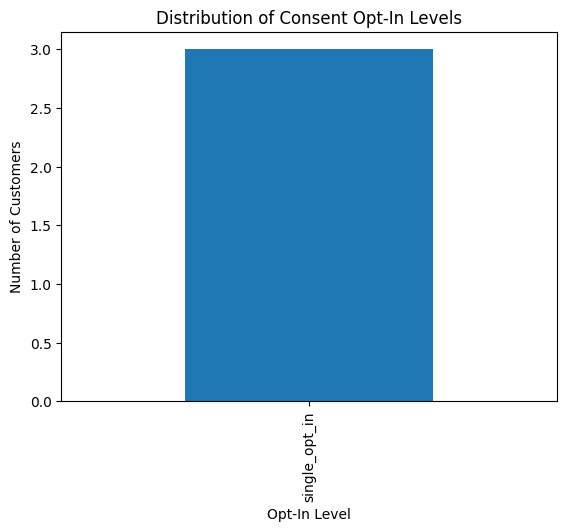

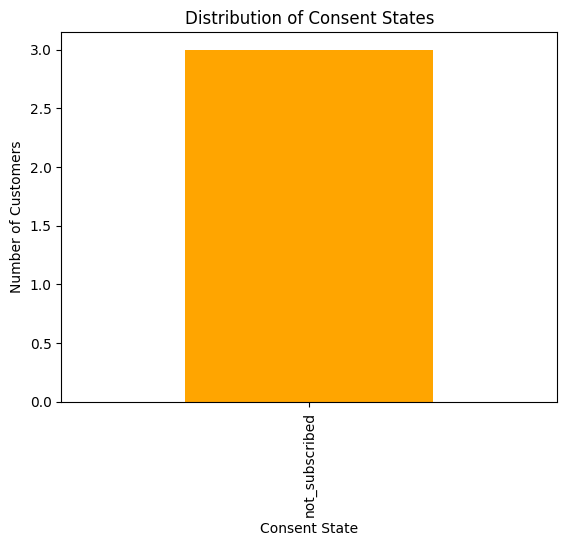

In [8]:
# Analyze the distribution of opt-in levels
opt_in_level_counts = customers['consent_opt_in_level'].value_counts()

# Analyze the distribution of consent states
consent_state_counts = customers['consent_state'].value_counts()

# Opt-in level distribution
opt_in_level_counts.plot(kind='bar')
plt.title('Distribution of Consent Opt-In Levels')
plt.xlabel('Opt-In Level')
plt.ylabel('Number of Customers')
plt.show()

# Consent state distribution
consent_state_counts.plot(kind='bar', color='orange')
plt.title('Distribution of Consent States')
plt.xlabel('Consent State')
plt.ylabel('Number of Customers')
plt.show()

### 3. Collection Popularity and Strategy
Analyze collections based on the number of products.

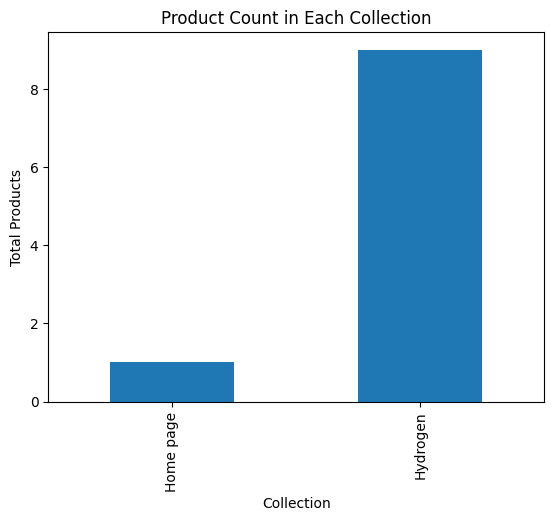

In [9]:
collections['products_count'] = pd.to_numeric(collections['products_count'], errors='coerce')
collections.groupby('title')['products_count'].sum().plot(kind='bar')
plt.title('Product Count in Each Collection')
plt.xlabel('Collection')
plt.ylabel('Total Products')
plt.show()

### 4. Inventory Analysis
Examine inventory levels across product variants.

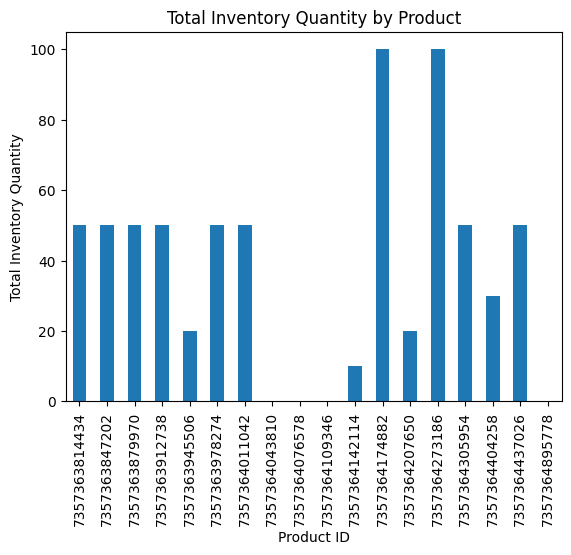

In [10]:
# Product Variants Inventory Analysis
product_variants.groupby('product_id')['inventory_quantity'].sum().plot(kind='bar')
plt.title('Total Inventory Quantity by Product')
plt.xlabel('Product ID')
plt.ylabel('Total Inventory Quantity')
plt.show()